In [93]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.externals.six import StringIO 
import graphviz
from IPython.display import Image
import pydotplus

pd.set_option('display.max_columns', None)
%matplotlib inline

In [94]:
df3 = pd.read_csv('data/preprocessed_data.csv')
df3 = df3.drop(df3.columns[0], axis=1)
df3.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,readmitted,service_utilization,num_diabetes_meds,change|num_medications,time_in_hospital|num_medications,num_medications|num_procedures,num_lab_procedures|time_in_hospital,num_medications|num_lab_procedures,num_medications|number_diagnoses,age|number_diagnoses,number_diagnoses|time_in_hospital,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,admission_type_1,admission_type_3,admission_type_4,admission_type_5,disch_dispo_1,disch_dispo_2,disch_dispo_7,disch_dispo_10,disch_dispo_18,disch_dispo_27,disch_dispo_28,admission_source_1,admission_source_2,admission_source_3,admission_source_4,admission_source_5,admission_source_6,admission_source_7,admission_source_8,admission_source_9,admission_source_10,admission_source_11,admission_source_13,admission_source_14,admission_source_17,admission_source_20,admission_source_22,admission_source_25,level1_diag_0.0,level1_diag_1.0,level1_diag_2.0,level1_diag_3.0,level1_diag_4.0,level1_diag_5.0,level1_diag_6.0,level1_diag_7.0,level1_diag_8.0,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1C_>7,A1C_>8,A1C_None,A1C_Norm
0,0,5,1,41,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,41,41,1,5,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1,0,15,3,59,0,18,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,18,54,0,177,1062,162,135,27,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,25,2,11,5,13,2,0,1,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,26,65,22,143,78,150,12,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,1,35,2,44,1,16,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,16,32,16,88,704,112,245,14,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,1,45,1,51,0,8,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2,8,8,0,51,408,40,225,5,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [95]:
# generate feature set and identify target variable
X = df3.loc[:, df3.columns != 'readmitted']
y = df3['readmitted']

#### Decision Tree Classification

In [96]:
print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTE(random_state=42)
X_new, y_new = smt.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(y_new)))

Original dataset shape Counter({0: 64139, 1: 6296})
New dataset shape Counter({0: 64139, 1: 64139})


In [97]:
X_new = pd.DataFrame(X_new, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=25, criterion = 'gini', min_samples_split=10)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

In [98]:
print("Cross Validation Score: ", cross_val_score(dtree, X_train, y_train, cv=10))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Cross Validation Score:  [0.90658056 0.90335152 0.90110257 0.8975387  0.90756209 0.91168282
 0.90678249 0.90477781 0.90956677 0.91112596]
Accuracy:  0.9102224301008212


In [99]:
print("Confusion Matrix:")
pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

Confusion Matrix:


Predict,0,1,All
Actual,,,
0,17797,1600,19397
1,1855,17232,19087
All,19652,18832,38484


In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91     19397
           1       0.92      0.90      0.91     19087

   micro avg       0.91      0.91      0.91     38484
   macro avg       0.91      0.91      0.91     38484
weighted avg       0.91      0.91      0.91     38484



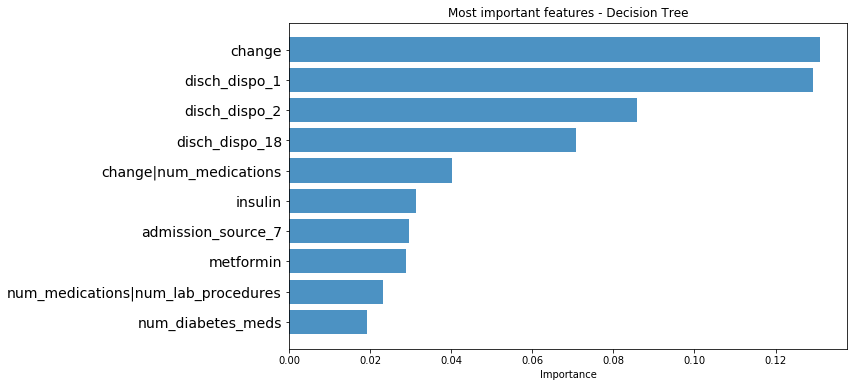

In [101]:
# Create list of most important features
feature_names = X_train.columns
feature_imports = dtree.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree')
plt.show()

In [102]:
dt_accuracy = accuracy_score(y_test, y_pred)
dt_precision = precision_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)
dt_auc_score = roc_auc_score(y_test, y_pred)

print("Accuracy: ", dt_accuracy)
print("Precision: ", dt_precision)
print("Recall: ", dt_recall)
print("AUC: ", dt_auc_score)

Accuracy:  0.9102224301008212
Precision:  0.9150382327952421
Recall:  0.9028134332268036
AUC:  0.9101632253518666


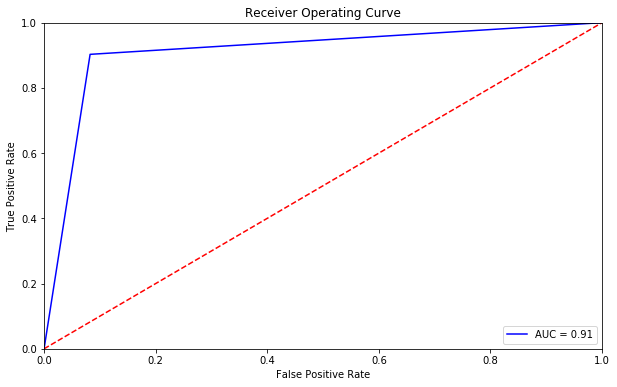

In [103]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.title('Receiver Operating Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [104]:
# dot_dt_q2 = tree.export_graphviz(dtree, out_file="dt_q2.dot", feature_names=X_train.columns, max_depth=2, 
#                                  class_names=["No","Readm"], filled=True, rounded=True, special_characters=True)
# graph_dt_q2 = pydotplus.graph_from_dot_file('dt_q2.dot')
# Image(graph_dt_q2.create_png())

In [105]:
# dot_data = StringIO()
# export_graphviz(dtree, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

#### Random Forest Classification

In [106]:
print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTE(random_state=42)
X_new, y_new = smt.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(y_new)))

Original dataset shape Counter({0: 64139, 1: 6296})
New dataset shape Counter({0: 64139, 1: 64139})


In [107]:
X_new = pd.DataFrame(X_new, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = 'gini', min_samples_split=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [108]:
print("Cross Validation Score: ", cross_val_score(clf, X_train, y_train, cv=10))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Cross Validation Score:  [0.93909364 0.93953903 0.9370754  0.93117274 0.93785499 0.94164161
 0.93874596 0.93484798 0.94119612 0.94342354]
Accuracy:  0.9420538405571146


In [109]:
print("Confusion Matrix:")
pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

Confusion Matrix:


Predict,0,1,All
Actual,,,
0,19215,182,19397
1,2048,17039,19087
All,21263,17221,38484


In [110]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.95     19397
           1       0.99      0.89      0.94     19087

   micro avg       0.94      0.94      0.94     38484
   macro avg       0.95      0.94      0.94     38484
weighted avg       0.95      0.94      0.94     38484



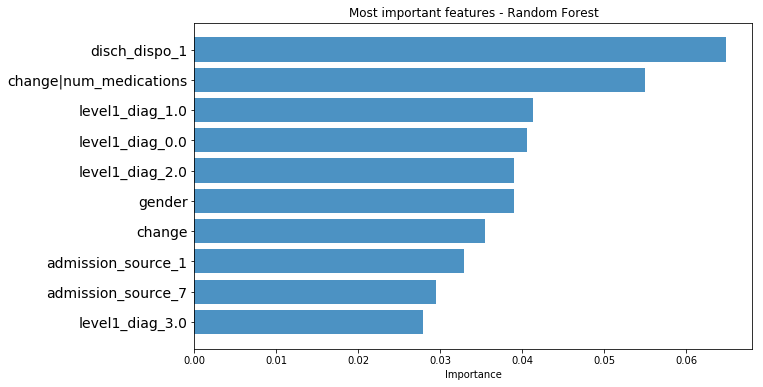

In [111]:
# Create list of most important features
feature_names = X_train.columns
feature_imports = clf.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest')
plt.show()

In [112]:
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_auc_score = roc_auc_score(y_test, y_pred)

print("Accuracy: ", rf_accuracy)
print("Precision: ", rf_precision)
print("Recall: ", rf_recall)
print("AUC: ", rf_auc_score)

Accuracy:  0.9420538405571146
Precision:  0.9894315080425062
Recall:  0.8927018389479751
AUC:  0.941659472342988


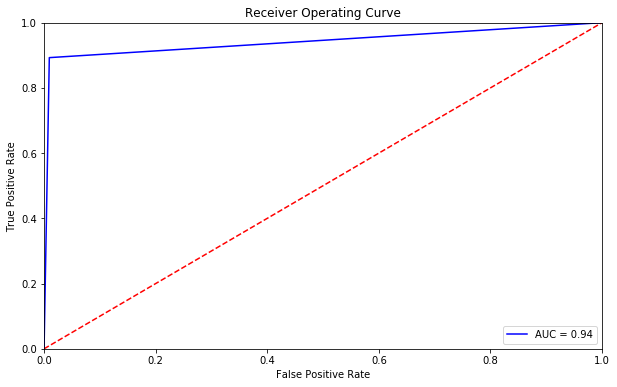

In [113]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.title('Receiver Operating Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [114]:
# compare model performance in visuals
decision_tree = [dt_accuracy, dt_precision, dt_recall, dt_auc_score]
random_forest = [rf_accuracy, rf_precision, rf_recall, rf_auc_score]

d = {'score': ['accuracy', 'precision', 'recall', 'auc_score'], 
     'decision_tree': decision_tree,
     'random_forest': random_forest}

score_df = pd.DataFrame(data=d)
score_df

,score,decision_tree,random_forest
0,accuracy,0.910222,0.942054
1,precision,0.915038,0.989432
2,recall,0.902813,0.892702
3,auc_score,0.910163,0.941659


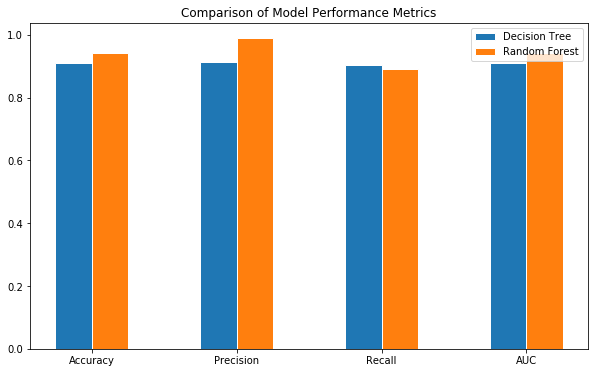

In [115]:
barWidth = 0.25

r1 = np.arange(len(decision_tree))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(10,6))
plt.title('Comparison of Model Performance Metrics')
plt.bar(r1, decision_tree, width=barWidth, edgecolor='white', label='Decision Tree')
plt.bar(r2, random_forest, width=barWidth, edgecolor='white', label='Random Forest')


plt.xticks([r + 0.125 for r in range(len(decision_tree))],labels=['Accuracy', 'Precision', 'Recall', 'AUC'])

plt.legend(loc = 'upper right')
plt.show()